In [1]:
!pip install wget

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tarfile
import wget
import os
import re
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load Data


In [4]:
print('Downloading dataset...')
url = 'http://www.statmt.org/europarl/v7/fr-en.tgz'

if not os.path.exists('./fr-en.tgz'):
    wget.download(url, './fr-en.tgz')

if not (os.path.exists('./europarl-v7.fr-en.fr') and os.path.exists('./europarl-v7.fr-en.en')):
    taf = tarfile.open("./fr-en.tgz")
    taf.extractall()

In [5]:
os.listdir()

['.config',
 'europarl-v7.fr-en.fr',
 'encoder_plot.png',
 'decoder_plot.png',
 'fr-en.tgz',
 'europarl-v7.fr-en.en',
 'sample_data']

# Prepare Data

In [0]:
def load_doc(filename):
	file = open(filename, mode='rt', encoding='utf-8')
	text = file.read()
	file.close()
	return text

In [0]:
def to_sentences(doc):
    return doc.strip().lower().split('\n')

In [0]:
def preprocess_sentence(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)    # pad punctuations with space on both sides 
    w = re.sub(r'[" "]+', " ", w)       # replace multiple spaces with a single space
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)      # replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
def create_dataset(num_samples):
    en = to_sentences(load_doc('./europarl-v7.fr-en.en'))
    fr = to_sentences(load_doc('./europarl-v7.fr-en.fr'))

    e_sents = [preprocess_sentence(w) for w in en]
    f_sents = [preprocess_sentence(w) for w in fr]


    return e_sents[:num_samples], f_sents[:num_samples]

In [0]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token="<unk>")
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def load_dataset(num_samples):
    en, fr = create_dataset(num_samples)
    en_tensor, en_tokenizer = tokenize(en)    
    fr_tensor, fr_tokenizer = tokenize(fr)

    return fr_tensor, en_tensor, fr_tokenizer, en_tokenizer

In [0]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(5000)

In [14]:
input_train, input_test, target_train, target_test = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_train), len(input_test), len(target_train), len(target_test))

4000 1000 4000 1000


In [15]:
inp_max_len, tar_max_len = max_length(input_train), max_length(target_train)
print(inp_max_len, tar_max_len)

168 143


In [0]:
BUFFER_SIZE = len(input_train)
BATCH_SIZE = 16
steps_per_epoch = len(input_train)//BATCH_SIZE
embedding_dim = 1000
units = 1000
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
example_input, example_target = next(iter(dataset))
example_input.shape, example_target.shape

(TensorShape([16, 168]), TensorShape([16, 143]))

# Model

In [0]:
# encoder
def define_encoder(max_len, vocab_size, embedding_dim, units):
    inp = tf.keras.Input((max_len))
    embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)(inp)
    output, state_h, state_c = tf.keras.layers.LSTM(units, return_state=True)(embedding)
    states = [state_h, state_c]
    model = tf.keras.Model(inp, [output,state_h, state_c])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 168)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 168, 1000)         8702000   
_________________________________________________________________
lstm (LSTM)                  [(None, 1000), (None, 100 8004000   
Total params: 16,706,000
Trainable params: 16,706,000
Non-trainable params: 0
_________________________________________________________________


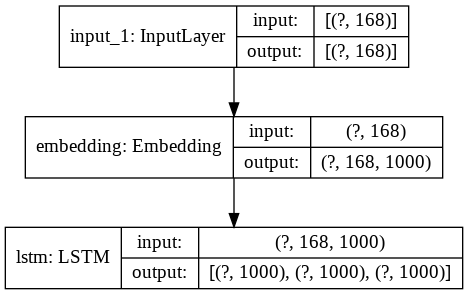

In [19]:
encoder = define_encoder(inp_max_len, vocab_inp_size, embedding_dim, units)
encoder.summary()
tf.keras.utils.plot_model(encoder, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
a, b, c = encoder(example_input)
a.shape, b.shape, c.shape

(TensorShape([16, 1000]), TensorShape([16, 1000]), TensorShape([16, 1000]))

In [0]:
# decoder
def define_decoder(max_len, vocab_size, embedding_dim, units):
    inp = tf.keras.Input((1))
    state_h = tf.keras.Input(shape=(units,))
    state_c = tf.keras.Input(shape=(units,))
    embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)(inp)
    output, state_2h, state_2c = tf.keras.layers.LSTM(units, activation='softmax', return_sequences=True, return_state=True)(embedding, initial_state=[state_h, state_c])
    output = tf.reshape(output, (-1, output.shape[2]))
    output = tf.keras.layers.Dense(vocab_size, activation='softmax')(output)
    model = tf.keras.Model([inp, state_h, state_c], [output, state_2h, state_2c])
    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 1000)      7544000     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1000)]       0                                            
____________________________________________________________________________________________

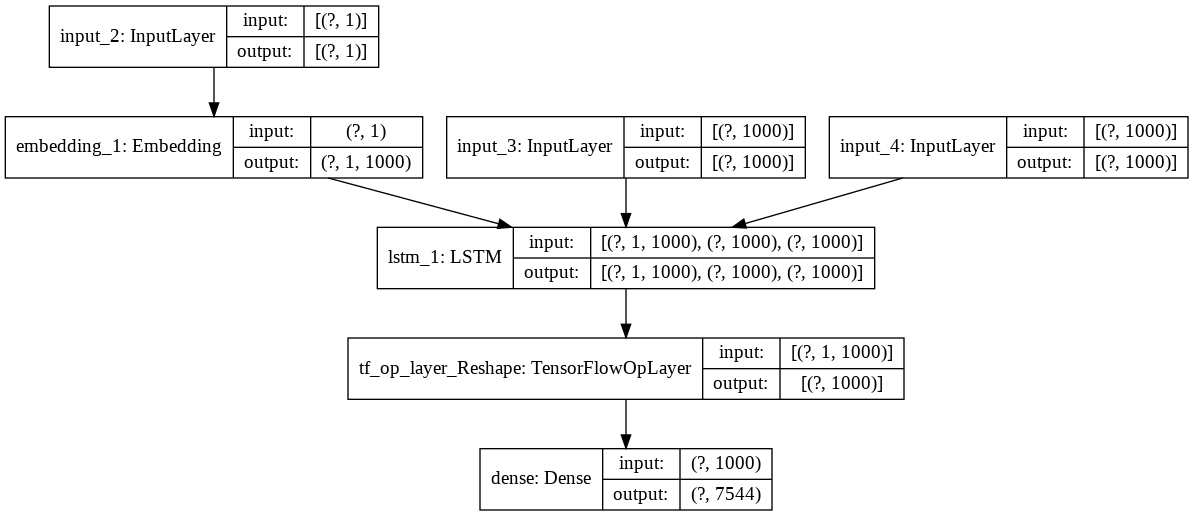

In [22]:
decoder = define_decoder(tar_max_len, vocab_tar_size, embedding_dim, units)
decoder.summary()
tf.keras.utils.plot_model(decoder, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
a2, b2, c2 = decoder([tf.random.uniform((BATCH_SIZE, 1)), b, c])
a2.shape, b2.shape, c2.shape

(TensorShape([16, 7544]), TensorShape([16, 1000]), TensorShape([16, 1000]))

# Train

In [0]:
opt = tf.keras.optimizers.Adam()
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_obj(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [0]:
EPOCHS = 8

In [0]:
@tf.function
def train_step(inp, targ):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden_h, enc_hidden_c = encoder(inp)
        dec_hidden_h = enc_hidden_h
        dec_hidden_c  = enc_hidden_c
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden_h, dec_hidden_c = decoder([dec_input, dec_hidden_h, dec_hidden_c])
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    opt.apply_gradients(zip(gradients, variables))
    return batch_loss

In [28]:
import time

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.8380
Epoch 1 Batch 100 Loss 1.9199
Epoch 1 Batch 200 Loss 2.2594
Epoch 1 Loss 1.8177
Time taken for 1 epoch 182.0148618221283 sec

Epoch 2 Batch 0 Loss 1.9551
Epoch 2 Batch 100 Loss 1.9277
Epoch 2 Batch 200 Loss 1.7131
Epoch 2 Loss 1.8176
Time taken for 1 epoch 91.29006886482239 sec

Epoch 3 Batch 0 Loss 1.9121
Epoch 3 Batch 100 Loss 1.9199
Epoch 3 Batch 200 Loss 1.9628
Epoch 3 Loss 1.8176
Time taken for 1 epoch 91.79377818107605 sec

Epoch 4 Batch 0 Loss 1.6857
Epoch 4 Batch 100 Loss 1.8534
Epoch 4 Batch 200 Loss 1.4786
Epoch 4 Loss 1.8173
Time taken for 1 epoch 92.32080125808716 sec

Epoch 5 Batch 0 Loss 1.5835
Epoch 5 Batch 100 Loss 1.9765
Epoch 5 Batch 200 Loss 2.1150
Epoch 5 Loss 1.8152
Time taken for 1 epoch 91.9244179725647 sec

Epoch 6 Batch 0 Loss 1.9466
Epoch 6 Batch 100 Loss 1.4225
Epoch 6 Batch 200 Loss 1.5858
Epoch 6 Loss 1.8115
Time taken for 1 epoch 91.71962571144104 sec

Epoch 7 Batch 0 Loss 1.6786
Epoch 7 Batch 100 Loss 1.5783
Epoch 7 Batch 200 L

# Translate

In [0]:
def evaluate(sentence):
    
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=inp_max_len, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    enc_out, enc_hidden_h, enc_hidden_c = encoder(inputs)

    dec_hidden_h = enc_hidden_h
    dec_hidden_c  = enc_hidden_c
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(tar_max_len):
        predictions, dec_hidden, attention_weights = decoder([dec_input, dec_hidden_h, dec_hidden_c])
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence

In [0]:
def translate(sentence):
    result, sentence = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))